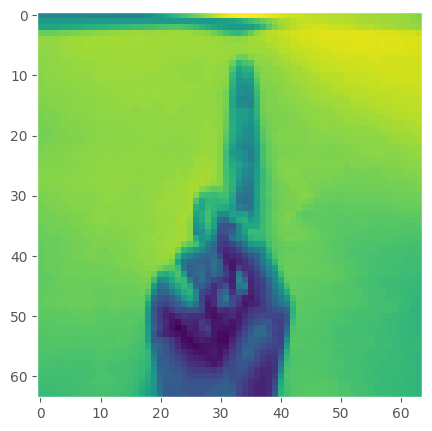

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

style.use("ggplot")

X = np.load("./archive/X.npy")
Y = np.load("./archive/Y.npy")

img_size = 64

plt.figure(figsize=(5, 5))
plt.imshow(X[1027].reshape(img_size, img_size))
plt.grid(0)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, train_size=0.95)
train_size = X_train.shape[0]
test_size = X_test.shape[0]

X_train.reshape((-1, 64, 64)).astype(np.float32)[:,:,:,None].shape

(1958, 64, 64, 1)

In [4]:
from torch.utils.data import Dataset, DataLoader
from torch import transpose
import torch
from torchvision import transforms
from PIL import Image
from torch import nn

class DataProcessing(Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data.reshape((-1, 64, 64)).astype(np.float32)
        self.target = torch.from_numpy(target).long()

    def __getitem__(self, index):
        return self.transform(self.data[index]), self.target[index]

    def __len__(self):
        return len(list(self.data))


C:\Users\xin\AppData\Local\Temp\ipykernel_14300\1697688164.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 1200 + 1) instead
  rnd = np.random.random_integers(0, 1200, 6)


[1126  860 1130 1095 1044  121]


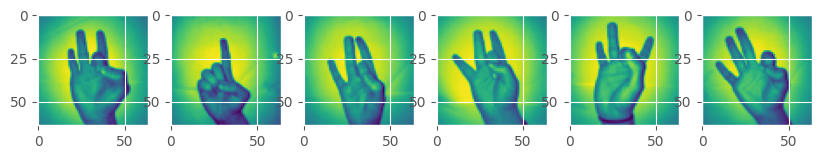

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(), transforms.ToTensor()
])

dt_train = DataProcessing(X_train, Y_train, transform=transform)
train_loader = DataLoader(dt_train, batch_size=4, shuffle=True, num_workers=4)

plt.figure(figsize=(10, 10))
np.random.seed(42)
rnd = np.random.random_integers(0, 1200, 6)
print(rnd)
for num, x in enumerate(rnd):
    plt.subplot(1, 6, num+1)
    plt.imshow(X[x])
    # plt.imshow(x)


In [6]:
class NNet(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.linear_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):

        x = self.cnn_layers(x)
        x = torch.flatten(x)

        x = self.linear_layers(x)
        return torch.nn.functional.log_softmax(x)


In [8]:

import torch.utils
import torch.utils.data


def train(model: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          cireterion: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader):

    model.train()
    pred_sum_len = 0
    correct_pred_sum = 0

    for batch_idx, (X, y) in enumerate(train_loader):
        if torch.cuda.is_available():
            X = X.to("cuda")
            y = y.to("cuda")

        optimizer.zero_grad()
        model_output = model(X)

        _, y_pred = torch.max(model_output, 1)
        print(torch.max(model_output, 1))
        correct_pred_sum += (y_pred == y).sum()
        pred_sum_len += y.size(0)

        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        if (batch_idx + 1) % 100 == 0:
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

    lr_scheduler.step()
    
    t_loss = (train_loss / len(train_loader))
    t_acc = (correct_pred_sum * 100 / pred_sum_len)

    return t_loss, t_acc

In [9]:
def evaluate(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader):
    model.eval()
    lr_scheduler.step()
    pred_sum_len = 0
    correct_pred_sum = 0
    loss = 0

    with torch.inference_mode():
        for batch_id, (X, y) in enumerate(train_loader):
            if torch.cuda.is_available():
                X = X.to("cuda")
                y = y.to("cuda")
            
            model_output = model(X)
            loss += torch.nn.functional.cross_entropy(y_pred, y)

            y_pred = torch.argmax(model_output, dim=1)
            correct_pred_sum += (y_pred == y).sum().item()
            pred_sum_len += y.size(0)

    loss /= len(train_loader.dataset)
    valid_loss = loss
    valid_acc = correct_pred_sum * 100 / pred_sum_len
    
    return valid_loss, valid_acc

In [10]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          cireterion: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          epochs: int = 5):
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train(model, optimizer, criterion, train_loader)
        test_loss, test_acc = evaluate(model, train_loader)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [ ]:
torch.manual_seed(42)

model = NNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    cireterion = criterion.cuda()

NUM_EPOCHS = 20

model_results = train(model, optimizer, criterion, dt_train, NUM_EPOCHS)

In [ ]:
torch.save({
    'epoch': NUM_EPOCHS, 
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()},
    f'checkpoint_{NUM_EPOCHS}_epchs.pth')   